In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable 
import numpy as np 
import tqdm 
from torch.utils import data 
import librosa
from scipy.io import wavfile
import json
import random
from scipy.signal import spectrogram

In [2]:
class Args(object):
    def __init__(self, name="Net", batch_size=4, test_batch_size=50,
                epochs=30, lr=1e-4, optimizer='Adam', momentum=0.9, weight_decay=0.0,
                seed=0, cuda = True):
        self.name = name;
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.weight_decay = weight_decay
        self.optimizer = optimizer
        self.momentum = momentum
        self.seed = seed
        self.cuda = cuda and torch.cuda.is_available()

In [3]:
# constants used for normalizing (in pixel coordinate)
com_traj_minx = -1476
com_traj_maxx = 1758
com_traj_miny = -678
com_traj_maxy = 1785

In [4]:

class Dataset(data.Dataset):
    
    def __init__(self, list_IDs, transform=None):
        #'Initialization'
        self.list_IDs = list_IDs
        self.transform = transform
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        # Generates one sample of data 
        ID = self.list_IDs[index]
        
        # Audio Feature Extraction
        filename = 'dataset_archive/audio/audio' + str(ID) + '.wav'
        srate, audio = wavfile.read(filename)
        audio = np.array(audio)
        
        for i in range(0,7):
            freq,t,phase = spectrogram(audio[:,i], nperseg=512 , noverlap=256, mode='phase')
            freq,t,mag = spectrogram(audio[:,i], nperseg=512, noverlap=256, mode='magnitude')
            if (i == 0):
                audio_phase = torch.from_numpy(phase).unsqueeze(2).float()
                audio_mag = torch.from_numpy(mag).unsqueeze(2).float()
            else:
                audio_phase = torch.cat((audio_phase, torch.from_numpy(phase).unsqueeze(2).float()),2)
                audio_mag = torch.cat((audio_mag, torch.from_numpy(mag).unsqueeze(2).float()),2)
        audio_img = torch.cat((audio_mag, audio_phase), 2)
        audio_img = audio_img.permute(1,0,2)
        
        complete_traj = np.load("dataset_archive/trajectory/traj"+str(ID)+".npy")
        complete_traj = (complete_traj[0] - complete_traj).astype(float)
        complete_traj[:,0] = (complete_traj[:,0] - com_traj_minx) / (com_traj_maxx - com_traj_minx)
        complete_traj[:,1] = (complete_traj[:,1] - com_traj_miny) / (com_traj_maxy - com_traj_miny)
    
        
        if complete_traj.shape[0] > 135:
            complete_traj = complete_traj[0:135,:]
        if complete_traj.shape[0] < 135:
            for i in range(0, 135 - complete_traj.shape[0]):
                complete_traj = np.append(complete_traj, complete_traj[-1].reshape(1,2), axis=0)    

        complete_traj = torch.from_numpy(complete_traj).type(torch.FloatTensor)

        return audio_img, complete_traj

In [5]:
# Read in index for train, validation, test
with open('partition.json') as f:
    partition = json.load(f)
args = Args()
params = {'batch_size': args.batch_size,
          'shuffle': True,
          'num_workers': 4}
# Generators
training_set = Dataset(partition['train'])
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['val'])
validation_generator = data.DataLoader(validation_set, **params)

In [6]:
class Encoder(nn.Module):
    """Encoder is part of both TrajectoryGenerator and
    TrajectoryDiscriminator"""
    def __init__(
        self, embedding_dim=64, h_dim=64, mlp_dim=1024, num_layers=1,
        dropout=0.0
    ):
        super(Encoder, self).__init__()

        self.mlp_dim = 1024
        self.h_dim = h_dim
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.encoder = nn.GRU(
            embedding_dim, h_dim, num_layers, dropout=dropout, bidirectional=True
        )
        self.spatial_embedding = nn.Linear(64, embedding_dim)

    def init_hidden(self, batch):
        return torch.zeros(self.num_layers*2, batch, self.h_dim).cuda()

    def forward(self, obs_traj):
        """
        Inputs:
        - obs_traj: Tensor of shape (obs_len, batch, 2)
        """
        # Encode observed Trajectory
        batch = obs_traj.size(1)
        state_tuple = self.init_hidden(batch)
        output, state = self.encoder(obs_traj, state_tuple)
        final_h = state[0]
        return output, final_h
    

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cn1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(5,5,14), padding=(1,1,3))
        self.batchNorm1 = nn.BatchNorm3d(64)
        self.pooling1 = nn.MaxPool3d(kernel_size = (1,8,1), stride=(1,4,1))
        self.cn2 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(5,5,7), padding=(1,1,2))
        self.batchNorm2 = nn.BatchNorm3d(64)
        self.pooling2 = nn.MaxPool3d(kernel_size = (1,8,1), stride=(1,4,1))
        self.cn3 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,5), padding=(1,1,1))
        self.batchNorm3 = nn.BatchNorm3d(64)
        self.pooling3 = nn.MaxPool3d(kernel_size = (1,4,1), stride=(1,2,1))
        self.cn4 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), padding=(1,0,0))
        self.batchNorm4 = nn.BatchNorm3d(64)
        self.pooling4 = nn.MaxPool3d(kernel_size = (1,4,1), stride=(1,2,1))
        
        self.encoder = Encoder(
            embedding_dim=64,
            h_dim=64,
            num_layers=1,
            dropout=0
        )
        
        self.encoder2 = Encoder(
            embedding_dim=64,
            h_dim=64,
            num_layers=1,
            dropout=0
        )
        
        self.ln = nn.Linear(128, 64)
        self.spatial_trimming1 = nn.Linear(555, 256)
        self.spatial_trimming2 = nn.Linear(256, 135)
        
        self.traj_predictor1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.2)
        self.traj_predictor2 = nn.Linear(64, 16)
        self.dropout1 = nn.Dropout(0.1)
        self.traj_predictor3 = nn.Linear(16, 2)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.cn1(x))
        x = self.batchNorm1(x)
        x = self.pooling1(x)
        x = F.relu(self.cn2(x))
        x = self.batchNorm2(x)
        x = self.pooling2(x)
        x = F.relu(self.cn3(x))
        x = self.batchNorm3(x)
        x = self.pooling3(x)
        x = F.relu(self.cn4(x))
        x = self.batchNorm4(x)
        x = self.pooling4(x)
        x = x.squeeze(4)
        x = x.squeeze(3)
        x = x.permute(2,0,1)
        x, _ = self.encoder(x)
        x = self.ln(x)
        x = torch.tanh(x)
        x, _ = self.encoder2(x)
        x = torch.tanh(x)
        x = x.permute(1,2,0)
        x = F.relu(self.spatial_trimming1(x))
        x = self.spatial_trimming2(x)
        x = x.permute(0,2,1)
        x = F.relu(self.traj_predictor1(x))
        x = self.dropout(x)
        x = F.relu(self.traj_predictor2(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.traj_predictor3(x))
        return x[:,:,0], x[:,:,1]

In [8]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
if args.cuda:
    model = model.cuda()
train_losses, train_accs = [], []
val_losses, val_accs = [], []
min_test_loss = 1000.
for epoch in range(args.epochs):
    # Training
    print("epoch " + str(epoch))
    model.train()
    
    total_loss, total_acc = 0., 0.
    progress_bar = tqdm.tqdm(training_generator, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        total_loss, total_acc = 0., 0.
        data = data.float()
        target = target.float()
        
        if args.cuda:
            data,target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss_x = F.mse_loss(output[0], target[:,:,0], reduction="sum")
        loss_y = F.mse_loss(output[1], target[:,:,1], reduction="sum")
        loss = loss_x + loss_y
        loss.backward()
        optimizer.step()
        train_losses.append(loss.data.item())
        
        total_loss += loss.data
        
        progress_bar.clear()
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}'.format(
                epoch, total_loss / (batch_idx + 1)))
        progress_bar.refresh()
        
    # Validation
    model.eval()
    test_loss, acc = 0., 0.
    progress_bar = tqdm.tqdm(validation_generator, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            data = data.float()
            target = target.float()
            if args.cuda:
                data,target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            data = data.float()
            output = model(data)
            loss_x = F.mse_loss(output[0], target[:,:,0], reduction="sum") 
            loss_y = F.mse_loss(output[1], target[:,:,1], reduction="sum")  # sum up batch loss
            test_loss += (loss_x + loss_y)
    test_loss /= len(partition['val'])
    val_losses.append(test_loss.item())
    if epoch % 10 == 0 and epoch != 0:
        args.lr /= 5
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}'.format(
            epoch, test_loss))
    if (test_loss < min_test_loss):
        torch.save(model, "audio_checkpoint_new.pkl")
        min_test_loss = test_loss

Training:   0%|          | 0/288 [00:00<?, ?it/s]

epoch 0


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]
/home/frankbu/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/frankbu/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 0 validation test results - Average val_loss: 7.6984
epoch 1


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 6.2400
epoch 2


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 4.9082
epoch 3


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 4.1539
epoch 4


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 4.0578
epoch 5


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 3.8999
epoch 6


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 3.3138
epoch 7


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 3.6277
epoch 8


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 3.9823
epoch 9


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 5.3962
epoch 10


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 10 validation test results - Average val_loss: 3.3458
epoch 11


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 3.2851
epoch 12


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 12 validation test results - Average val_loss: 3.3976
epoch 13


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 13 validation test results - Average val_loss: 3.4224
epoch 14


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 3.2813
epoch 15


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 15 validation test results - Average val_loss: 3.4121
epoch 16


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 16 validation test results - Average val_loss: 3.3983
epoch 17


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 17 validation test results - Average val_loss: 3.4577
epoch 18


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 18 validation test results - Average val_loss: 3.3297
epoch 19


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 19 validation test results - Average val_loss: 3.3543
epoch 20


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 20 validation test results - Average val_loss: 3.2691
epoch 21


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 21 validation test results - Average val_loss: 3.2959
epoch 22


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 22 validation test results - Average val_loss: 3.4079
epoch 23


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 23 validation test results - Average val_loss: 3.3005
epoch 24


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 24 validation test results - Average val_loss: 3.4200
epoch 25


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 25 validation test results - Average val_loss: 3.3823
epoch 26


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 26 validation test results - Average val_loss: 3.4132
epoch 27


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 27 validation test results - Average val_loss: 3.3759
epoch 28


Training:   0%|          | 0/288 [00:00<?, ?it/s]


Epoch: 28 validation test results - Average val_loss: 3.3648
epoch 29


Validation: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Epoch: 29 validation test results - Average val_loss: 3.4194


In [9]:
val_losses

[7.698442459106445,
 6.240025043487549,
 4.908244609832764,
 4.153877258300781,
 4.057795524597168,
 3.8998873233795166,
 3.3137989044189453,
 3.6277015209198,
 3.9823100566864014,
 5.396233558654785,
 3.345834970474243,
 3.2851290702819824,
 3.397555112838745,
 3.4224469661712646,
 3.2813353538513184,
 3.4120523929595947,
 3.3982956409454346,
 3.4577383995056152,
 3.32967472076416,
 3.354292154312134,
 3.2690811157226562,
 3.2958803176879883,
 3.4079408645629883,
 3.3004636764526367,
 3.419959545135498,
 3.3823375701904297,
 3.4132039546966553,
 3.375885009765625,
 3.364790201187134,
 3.4193553924560547]

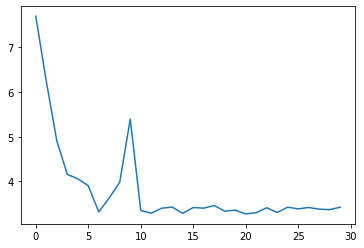

In [10]:
plt.plot(val_losses)